<a href="https://colab.research.google.com/github/nnajeh/Calssification/blob/main/Cats_Dogs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
cd /content/drive/MyDrive/Colab Notebooks/CNN/Classification/Dataset/Cats-Dogs

/content/drive/MyDrive/Colab Notebooks/CNN/Classification/Dataset/Cats-Dogs


In [20]:
#Import the necessiray library
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os


In [21]:
# The input of CNN (square image)
IMAGE_SIZE = 128
BATCH_SIZE = 32

In [27]:
#Data Path

test_images_dir = "test1/"
train_images_dir= "train/"
sample_sub_path = "sampleSubmission.csv"

In [28]:
import pandas as pd
# Submission example
submit_example = pd.read_csv(sample_sub_path)
submit_example.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [29]:
list_images_path = os.listdir(train_images_dir)
labels = []

In [30]:
#Loop the dataset and add the labels to the list
for image_path in list_images_path:
    if "cat" in image_path:
        labels.append('cat')
    else:
        labels.append('dog')

In [31]:
df = pd.DataFrame({"file":list_images_path, "label":labels})

print(df.head())
print(df.tail())

           file label
0  cat.9544.jpg   cat
1  cat.9562.jpg   cat
2  cat.9578.jpg   cat
3   cat.956.jpg   cat
4  cat.9574.jpg   cat
                file label
24995  dog.10473.jpg   dog
24996  dog.10468.jpg   dog
24997  dog.10472.jpg   dog
24998  dog.10442.jpg   dog
24999  dog.10451.jpg   dog


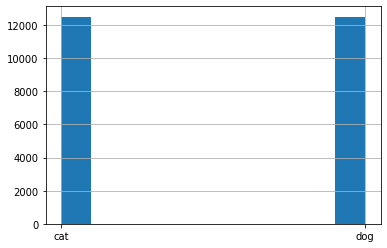

In [32]:
df['label'].hist()

In [33]:
from PIL import Image
import matplotlib.pyplot as plt

In [34]:
sample = np.random.randint(len(df))

img_path = train_images_dir + df['file'][sample]
label = df['label'][sample]

img = Image.open(img_path)

(-0.5, 348.5, 311.5, -0.5)

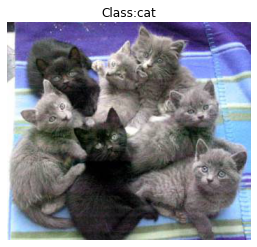

In [35]:
plt.imshow(img)
plt.title(f"Class:{label}")
plt.axis('off')


In [36]:
df.shape

(25000, 2)

In [37]:
#@title #Spliting the dataset


In [38]:
from sklearn.model_selection import train_test_split

In [39]:
#Split the dataset to train, test and validation(taken from train data(0.15))
train_df, valid_df = train_test_split(df, test_size = 0.15)

In [40]:
print("Train set:", train_df.shape)
print("Validation set:", valid_df.shape)

Train set: (21250, 2)
Validation set: (3750, 2)


In [41]:
train_df.head()

,file,label
16303,dog.7122.jpg,dog
18945,dog.4143.jpg,dog
20886,dog.2240.jpg,dog
19120,dog.4242.jpg,dog
20752,dog.2114.jpg,dog


In [42]:
#@title #Data augmentation




In [43]:

from keras.preprocessing.image import ImageDataGenerator

In [44]:
train_gen = ImageDataGenerator(rescale = 1.0/255.0,
                               horizontal_flip = True,
                               vertical_flip   = True,
                               fill_mode = 'nearest',
                               rotation_range = 10,
                               width_shift_range = 0.2,
                               height_shift_range= 0.2,
                               shear_range= 0.15,
                               brightness_range= (.5,1.2),
                               zoom_range = 0.2)

In [45]:
train_gen = train_gen.flow_from_dataframe(train_df,
                                          directory = train_images_dir,
                                          x_col = 'file', 
                                          y_col = 'label', 
                                          target_size =(IMAGE_SIZE, IMAGE_SIZE), 
                                          class_mode = 'categorical',
                                          batch_size = BATCH_SIZE, 
                                          color_mode = 'rgb', 
                                          shuffle = True)

Found 21250 validated image filenames belonging to 2 classes.


(32, 128, 128, 3)


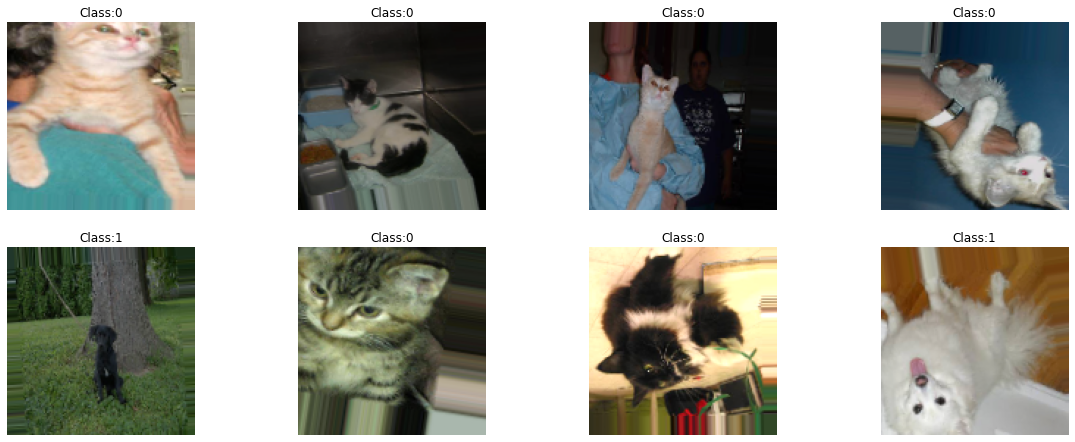

In [46]:
#Verify generated images
n_samples = 8

plt.figure(figsize=(20,20))

for x_gens, y_gens in train_gen:
#     the first dimension of x_gens and y_gens will be equal to batch_size specifed previously
    print(x_gens.shape)
    i = 0
    for sample_img, sample_class in zip(x_gens, y_gens):
        
        plt.subplot(5,4,i+1)
        plt.title(f'Class:{np.argmax(sample_class)}')
        plt.axis('off')
        plt.imshow(sample_img)
        
        i += 1
        
        if i >= n_samples:
            break
    break


In [47]:
valid_gen = ImageDataGenerator(rescale=1./255)
valid_gen = valid_gen.flow_from_dataframe( valid_df, 
                                           directory = train_images_dir,
                                           x_col='file',
                                           y_col='label',
                                           target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE)

Found 3750 validated image filenames belonging to 2 classes.


In [ ]:
#@title The model


In [48]:
from tensorflow import keras

In [49]:
def myModel(input_shape):
    
    X_input = keras.layers.Input(shape=input_shape, name='input')
    
#     128x128x3
    
    X = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', name='conv-1')(X_input)    
    X = keras.layers.BatchNormalization(name='b1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)
    
#     64x64x32
    
    X = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', name='conv-2')(X)    
    X = keras.layers.BatchNormalization(name='b2')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)
#     32x32x64

    X = keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', name='conv-3')(X)    
    X = keras.layers.BatchNormalization(name='b3')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)

#     16x16x128
    
    X = keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', name='conv-4')(X)    
    X = keras.layers.BatchNormalization(name='b4')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)

#     8x8x128
    
    X = keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', name='conv-5')(X)    
    X = keras.layers.BatchNormalization(name='b5')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)
    
#     8x8x128
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(units=512, name='fc-6')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(0.3)(X)
    
    X = keras.layers.Dense(units=2, activation='softmax', name='output')(X)
    
    model = keras.Model(inputs = X_input, outputs = X, name='My_CNN_Model')
    
    return model

In [50]:
model = myModel((IMAGE_SIZE,IMAGE_SIZE,3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "My_CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv-1 (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
b1 (BatchNormalization)      (None, 128, 128, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv-2 (Conv2D)              (None, 64, 64, 64)       

In [ ]:
#@title Training


In [51]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [52]:
# To stop the training after N epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=2)
# To reduce the learning rate when the accuracy not increase for 5 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [53]:
# callbacks = [earlystop, learning_rate_reduction]
callbacks = [earlystop]

In [54]:
# model.load_weights("./weights.h5")
epochs = 10
history = model.fit(train_gen, 
                    steps_per_epoch = len(train_df)//BATCH_SIZE, 
                    epochs = epochs, 
                    validation_data = valid_gen, 
                    validation_steps = len(valid_df)//BATCH_SIZE)

Epoch 1/10
664/664 [==============================] - 4661s 7s/step - loss: 0.8025 - accuracy: 0.5465 - val_loss: 0.6861 - val_accuracy: 0.5582
Epoch 2/10
664/664 [==============================] - 171s 258ms/step - loss: 0.6652 - accuracy: 0.6023 - val_loss: 0.6573 - val_accuracy: 0.6207
Epoch 3/10
664/664 [==============================] - 171s 257ms/step - loss: 0.6254 - accuracy: 0.6482 - val_loss: 0.6827 - val_accuracy: 0.6565
Epoch 4/10
664/664 [==============================] - 169s 254ms/step - loss: 0.6023 - accuracy: 0.6694 - val_loss: 0.6071 - val_accuracy: 0.6680
Epoch 5/10
664/664 [==============================] - 168s 253ms/step - loss: 0.5755 - accuracy: 0.6964 - val_loss: 0.6157 - val_accuracy: 0.6517
Epoch 6/10
664/664 [==============================] - 166s 251ms/step - loss: 0.5468 - accuracy: 0.7227 - val_loss: 0.4949 - val_accuracy: 0.7671
Epoch 7/10
664/664 [==============================] - 166s 250ms/step - loss: 0.5409 - accuracy: 0.7273 - val_loss: 0.7574 - v

In [56]:
# Saving the weights
model.save_weights('/content/drive/MyDrive/Data/weights_v3.h5')

In [ ]:
#@title Evaluating


In [57]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
print("Accuracy = ", history.history['accuracy'][-1])
print("Val. Accuracy = ", history.history['val_accuracy'][-1])

Accuracy =  0.7880573272705078
Val. Accuracy =  0.7994123697280884


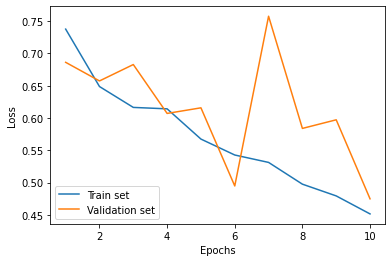

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs, loss, label='Train set')
plt.plot(epochs, val_loss, label='Validation set')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

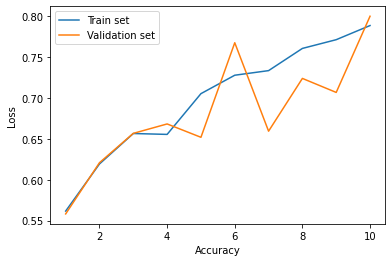

In [60]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1,len(loss)+1)

plt.plot(epochs, accuracy, label='Train set')
plt.plot(epochs, val_accuracy, label='Validation set')

plt.legend()
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.show()

In [61]:
#@title Predicting form test subset

In [62]:
test_images_path = os.listdir(test_images_dir)
test_df = pd.DataFrame({'file':test_images_path})
test_df.head()

,file
0,11469.jpg
1,11445.jpg
2,11515.jpg
3,11523.jpg
4,11565.jpg


In [63]:
test_gen = ImageDataGenerator(rescale=1.0/255.0)
test_gen = test_gen.flow_from_dataframe(test_df, 
                                        directory=test_images_dir, 
                                        x_col='file', 
                                        y_col=None,
                                        class_mode=None,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        color_mode="rgb",
                                        shuffle = False)

Found 12500 validated image filenames.


In [64]:
predictions = model.predict(test_gen)

In [65]:
predictions = np.argmax(predictions,axis=1)
predictions.shape

(12500,)

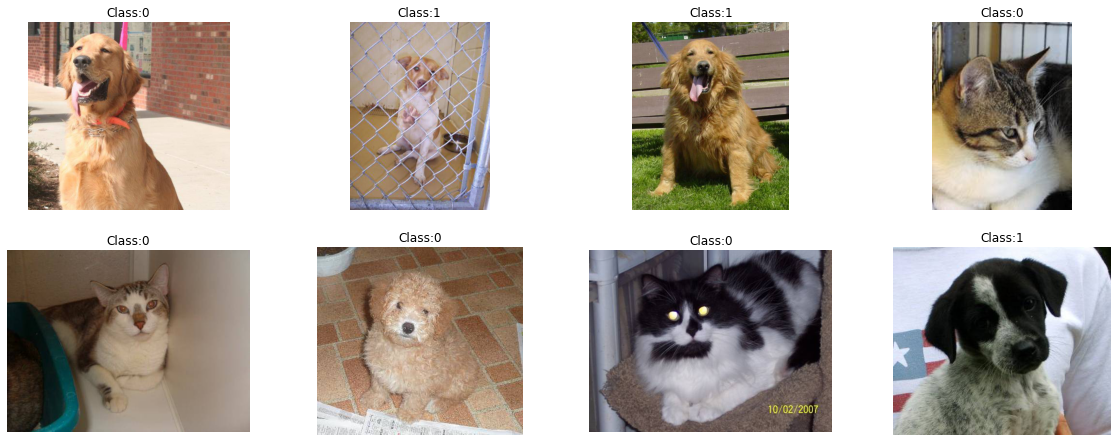

In [66]:
nsamples = 8

plt.figure(figsize=(20,20))
for i, file in enumerate(test_df['file'][:nsamples]):
    img = Image.open(test_images_dir+file)
    
    plt.subplot(5,4, i+1)
    plt.imshow(img)
    plt.title(f"Class:{predictions[i]}")
    plt.axis('off')

In [67]:
submit_df = pd.DataFrame()
submit_df['id'] = range(1,len(predictions)+1)
submit_df['label'] = predictions

submit_df.to_csv('./submission.csv', index=False)

submit_df.head(10)

,id,label
0,1,0
1,2,1
2,3,1
3,4,0
4,5,0
5,6,0
6,7,0
7,8,1
8,9,0
9,10,0
